# 이미지 분류를 위한 데이터 전처리

---

In [1]:
from glob import glob
import os
import numpy as np
import pydicom
#import skimage.external.tifffile 
import matplotlib.pyplot as plt
#import imsave
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

---
## y_label

- 0과 1의 라벨링
- 다만 총 6개의 사진당 하나의 label이 부여되는 것을 고려해야한다

In [2]:
y_train = pd.read_csv("C:\\Users\\default.DESKTOP-2ISHQBS\\lab\\task3_dcm\\train_y_label.csv")
y_test = pd.read_csv("C:\\Users\\default.DESKTOP-2ISHQBS\\lab\\task3_dcm\\y_test.csv")

In [3]:
y_train.shape, y_test.shape

((331, 1), (126, 1))

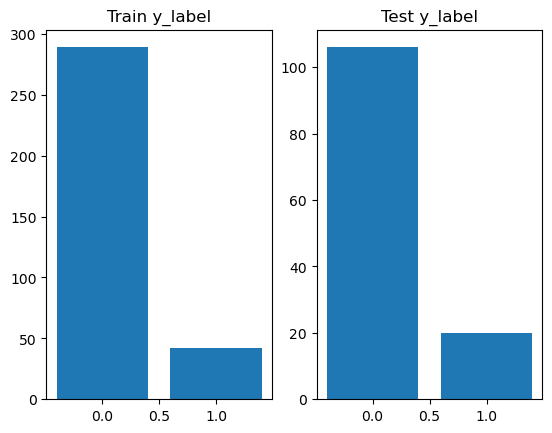

In [4]:
fig, ax = plt.subplots(1, 2)

# Train 
u_train, c_train = np.unique(y_train, return_counts=True)
ax[0].bar(u_train, c_train, width=0.8, align='center')  
ax[0].set_title('Train y_label')

# Test
u_test, c_test = np.unique(y_test, return_counts=True)
ax[1].bar(u_test, c_test, width=0.8, align='center')  
ax[1].set_title('Test y_label')

plt.show()


## input_X

- train에서 규칙에서 벗어난 사진이 있음 133부턴 0이아니라 5가 다른 사진임
- 규격이 다르기 때문에 꼭 따로 훈련을 시켜야할 것으로 보인다
- array([ 10,  17,  24,  35, 117, 156, 160, 181, 195, 209, 219, 228, 269,
       273, 297]) 훈련셋 누락
- array([  8,  72,  74, 104, 113, 115, 119, 123, 131, 135]) 테스트셋 누락

In [5]:
##################################################################################
# 파일 주소 

dir_train = 'C:\\Users\\default.DESKTOP-2ISHQBS\\lab\\task3_dcm\\X_train\\'
dir_test = 'C:\\Users\\default.DESKTOP-2ISHQBS\\lab\\task3_dcm\\X_test\\'
# dcm 파일 all reading 
dcm_files_train = glob(os.path.join(dir_train, '*.tif'))
dcm_files_test = glob(os.path.join(dir_test, '*.tif'))

##################################################################################
# 같은 쉐잎을 가지고 있는 데이터만 우선 적용할 예정
# train은 0마다 다른 흉상사진, test는 5마다 다른 흉상사진
# 우선 제외하려고함
#num_true_train  = [dcm_files_train[i][-5] != '0' for i in range(len(dcm_files_train))]
#num_true_test = [dcm_files_test[i][-5] != '5' for i in range(len(dcm_files_test))]

###################################################################################
# 데이터프레임을 이용하여 논리연산자로 제외하고 싶은 사진을 제거

#train_ad_df= pd.DataFrame(dcm_files_train)#[num_true_train]
#test_ad_df =pd.DataFrame(dcm_files_test)#[num_true_test]

In [6]:
def preprocess_grayscale(file_path, target_size=(224, 224)):
    # 이미지 불러오기
    image = Image.open(file_path)
    
    # 이미지 크기 조정
    image = image.resize(target_size)
    
    # 이미지를 흑백으로 변환
    #image = image.convert('L')
    
    # 이미지를 넘파이 배열로 변환 및 정규화
    image_array = np.array(image) / 255.0  # 정규화 (0~1 범위로)
    
    # 모델에 입력으로 제공하기 위해 넘파이 배열의 형태 변환 (차원 추가)
    image_array = np.expand_dims(image_array, axis=2)
    
    return image_array


In [7]:
X_train = np.array([preprocess_grayscale(dcm_files_train[i]) for i in range(len(dcm_files_train))])
X_test = np.array([preprocess_grayscale(dcm_files_test[i]) for i in range(len(dcm_files_test))])

In [8]:
X_train = np.tile(X_train, (1, 1, 1, 3)) # rgb 흑백이어서 채널을 늘리는 것
X_test = np.tile(X_test, (1, 1, 1, 3))

In [9]:
X_train.shape, X_test.shape

((1655, 224, 224, 3), (630, 224, 224, 3))

In [10]:

X_train_seq = []
for i in range(0,int(len(X_train)/5)):
    a =X_train[i:i+5]
    X_train_seq.append(a)
    
    
    
X_test_seq = []
for i in range(0,int(len(X_test)/5)):
    a =X_test[i:i+5]
    X_test_seq.append(a)
    

X_train_seq = np.array(X_train_seq)
X_test_seq = np.array(X_test_seq)

X_train_seq.shape, X_test_seq.shape


((331, 5, 224, 224, 3), (126, 5, 224, 224, 3))

In [11]:
y_train.shape, y_test.shape

((331, 1), (126, 1))

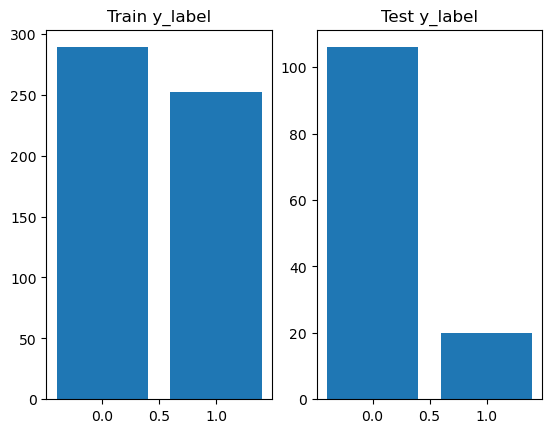

In [12]:
d= list(enumerate(y_train.values[:].flatten()))


f= [d[i][1] == 1 for i in range(len(d))]
f2= [d[i][1] != 1 for i in range(len(d))]

X_train_y_times5= np.concatenate([X_train_seq[f],X_train_seq[f],X_train_seq[f],X_train_seq[f],X_train_seq[f],X_train_seq[f]])
y_train_y_times5= np.concatenate([y_train[f],y_train[f],y_train[f],y_train[f],y_train[f],y_train[f]])

X= np.concatenate([X_train_y_times5,X_train_seq[f2]])
y=np.concatenate([y_train_y_times5,y_train[f2]])

np.random.seed(1)
indices = np.arange(len(X))

# 인덱스 셔플
np.random.shuffle(indices)

# 셔플된 인덱스를 사용하여 데이터를 섞음
shuffled_X = X[indices]
shuffled_y = y[indices]

fig, ax = plt.subplots(1, 2)

# Train 
u_train, c_train = np.unique(shuffled_y, return_counts=True)
ax[0].bar(u_train, c_train, width=0.8, align='center')  
ax[0].set_title('Train y_label')

# Test
u_test, c_test = np.unique(y_test, return_counts=True)
ax[1].bar(u_test, c_test, width=0.8, align='center')  
ax[1].set_title('Test y_label')

plt.show()